In [1]:
#FIRST CELL: set these variables to limit GPU usage.
import os 
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' #this is required
os.environ['CUDA_VISIBLE_DEVICES'] = '1' #set to '0' for GPU0, '1' for GPU1 or '2' for GPU2

In [2]:
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import tree
import collections
import sys
import numpy
import pickle
import pprint
import re
from sklearn import tree
from numba import jit, cuda

In [3]:
def selection_extention(trimmed_set):
    each_x = math.ceil(len(trimmed_set) / 20)
    if(each_x <= 0):
        trimmed_set = trimmed_set
    else:
        trimmed_set = trimmed_set[::each_x]
    
    trimmed_set = trimmed_set.reset_index()
        
    for i in range(20 - len(trimmed_set)):
        time = trimmed_set['time'][len(trimmed_set)-1] + 1
        trimmed_set.loc[trimmed_set.shape[0]] = [0,0,0,0,0,0,0,0,0,0,time]
        
    trimmed_set.drop('time', inplace=True, axis=1)
    trimmed_set.drop('id', inplace=True, axis=1)
    trimmed_set.drop('userName', inplace=True, axis=1)
    trimmed_set.drop('gestureName', inplace=True, axis=1)
    trimmed_set.drop('index', inplace=True, axis=1)
    
    return trimmed_set

In [4]:
def convert_to_np(dataset):
    arr2d = dataset.to_numpy()
    arr1d = arr2d.flatten()
    
    #print(arr2d)
    
    return arr1d

In [5]:
%%time
path = "recordiong_new"
all_folders = os.listdir(path)
all_folders.sort(key=int)

all_dataset = {}
calibration = {}

all_dataset['label'] = list()
all_dataset['data'] = list()

if os.path.exists('pickle.pk1') is False:

    for folder in all_folders:
        data_path = path + "/" + folder + "/daten"
        csvlist = os.listdir(data_path)
        csvlist.sort()

        for csv in csvlist:
            if (os.path.isfile(data_path + "/" + csv)):
                data = pd.read_csv(data_path + "/" + csv, delimiter=";", index_col = False)
                calc_time_from_row_count = (data.shape[0] * 10)
                
                if (calc_time_from_row_count >= 50 and calc_time_from_row_count <= 300):
                    subStr = re.findall(r'_(.+?)_',csv)
                    all_dataset['label'].append(subStr)
                    data = selection_extention(data)
                    all_dataset['data'].append(convert_to_np(data))
                    #all_dataset['data'].append(data)

    pickle.dump(all_dataset, open('pickle.pk1', 'wb'))

else:
    all_dataset =  pickle.load(open('pickle.pk1', 'rb'))

CPU times: user 6.22 s, sys: 17.6 ms, total: 6.24 s
Wall time: 6.24 s


In [6]:
X, y = all_dataset["data"], all_dataset["label"]
train_data, val_data, train_labels, val_labels = train_test_split(X, y, test_size=0.5)
train_labels = numpy.array(train_labels).flatten()

In [7]:
model = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state =1)
model.fit(train_data, train_labels)
predicted_labels = model.predict(val_data)

print(train_labels.shape)

                  
print(classification_report(numpy.array(val_labels), predicted_labels))
model_file_name = 'model.sav'
pickle.dump(model, open(model_file_name, 'wb'))

(200,)
                  precision    recall  f1-score   support

       Clockwise       1.00      0.98      0.99        50
CounterClockwise       1.00      1.00      1.00        47
             Nod       1.00      1.00      1.00        50
           Shake       0.98      1.00      0.99        53

        accuracy                           0.99       200
       macro avg       1.00      0.99      1.00       200
    weighted avg       1.00      0.99      0.99       200



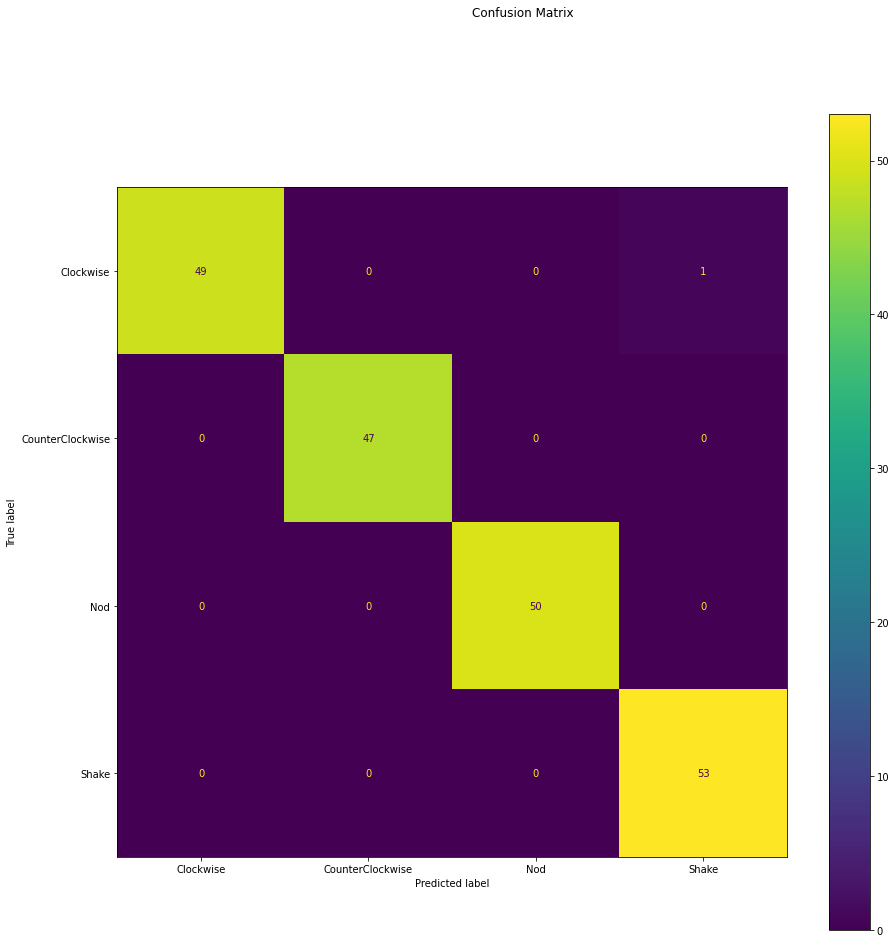

In [8]:
fig, ax = plt.subplots(figsize=(15,15))

disp = ConfusionMatrixDisplay.from_predictions(numpy.array(val_labels), predicted_labels, ax=ax)
disp.figure_.suptitle("Confusion Matrix")

plt.show()

In [19]:
# LAST CELL: Kill the kernel in the end to prevent idle kernels
exit()